In [374]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from ast import literal_eval
import matplotlib.pyplot as plt

# functions for pipeline

In [375]:
def drop_categories(df):
    # this function drops all categories of API output which are irrelevant for prediction
    
    # keep only important columns
    df.drop(["dlc", "review_score_desc", "legal_notice", "recommendations", "ext_user_account_notice", "reviews", "metacritic", "demos", 
            "drm_notice", "alternate_appid", "screenshots", "movies", "support_info", "background", "background_raw", 
            "content_descriptors", "packages", "package_groups", "num_reviews", "developers", "achievements", 
            "detailed_description", "about_the_game", "supported_languages", "header_image", "website", "categories_clean", "genres_clean"
            ], axis = 1, inplace=True)

    # remove russian categories 
    df.drop(['Контроллер (полностью)',  'Remote Play на телевизоре', 'Достижения Steam',  'Для нескольких игроков', 'Статистика', 'Коллекционные карточки', 
            'Покупки внутри приложения','Remote Play на телефоне', 'Мастерская Steam', 'Имеется античит Valve', 'Remote Play на планшете',
            ], axis = 1, inplace=True)

    # keep only important categories
    df.drop(['Partial Controller Support', 'Captions available', 'Remote Play on Phone',  'Steam Turn Notifications', 'Steam Trading Cards',
            'Remote Play on TV', 'Includes Source SDK', 'SteamVR Collectibles', 'Commentary available', 'Includes level editor', 
            'Tracked Controller Support',  'Steam Workshop', 'Additional High-Quality Audio', 'Steam Cloud', 'Remote Play on Tablet'
            ], axis = 1, inplace=True)

    # remove russian genres 
    df.drop(['Экшены','Бесплатно', 'Дизайн и иллюстрация', 'Создание видео', 'Анимация и моделирование'], axis = 1, inplace=True)

    # keep only important genres
    df.drop(['Design & Illustration', 'Audio Production', 'Photo Editing', 'Video Production', 'Game Development', 'Software Training',
                'Web Publishing', 'Animation & Modeling', 'Utilities'], axis = 1, inplace=True)

In [376]:
def drop_few_review_games(df, num_reviews=50):
    # drop games with less than num_reviews reviews. also reset the index after dropping rows
    df =  df.loc[lambda df: df['total_reviews'] >= num_reviews, :].reset_index(drop=True)
    return df

In [377]:
def clean_price(df):
    # Clean up "price_overview" output of API and add new column "price"
    # use price without discounts(initial)
    
    df["price"] = 0
    
    # iterate through rows
    for index, row in df.iterrows():
        
        # if free to play, keep 0
        if not row.is_free:
            
            # try to read the entry as a dictionary
            try:
                dict = literal_eval(str(row.price_overview).replace("''",'None'))
            
            # if not possible delete row
            except: 
                df.drop(index, inplace=True)
            
            # if possible
            else: 
                
                # if currency is not EUR
                if dict["currency"] != "EUR":
                    
                    # delete row
                    df.drop(index, inplace=True)
            
                # get price
                else:
                    df["price"].loc[index] = dict["initial"]
                    
    df = df.drop('price_overview', axis=1).reset_index(drop=True)
    
    return df


In [378]:
def drop_high_price_games(df, max_price=200):
    # drops few outlier games which have unreasonably high prices. max price is price in euros (price/100)
    df=  df.loc[lambda df: df['price']/100 <= max_price, :].reset_index(drop=True)
    return df

In [379]:
def clean_col(df, col):
    # this function takes the API output of the column genres and cleans it up
    #genres are shown in a list in new column "genres_clean" in output dataframe
    
    new_col = col + "_clean"
    
    df[new_col] = ""
    
    # iterate through rows
    for index, row in df.iterrows():
            
        # try to read the entry as a dictionary
        try:
            dict = literal_eval(str(row[col]).replace("''",'None'))
        
        # if not possible delete row
        except: 
            df.drop(index, inplace=True)
        
        # if possible
        else:
             
            genres = []
            
            for j in range(len(dict)):
                genres.append(dict[j]["description"])
            
            df[new_col].loc[index] = np.array(genres)
                    
    df = df.drop(col, axis=1).reset_index(drop=True)

    return df

In [380]:
def get_set(df, col):
    # this function iterates through the new column "genres_clean" and return the set of unique genres contained in the dataframe
    G = []
    
    for idx,row in df.iterrows():
        
        for j in range(len(row[col])):
            G.append(row[col][j])
    
    return list(set(G))
        

In [381]:
def one_hot_encode_platforms(df):
    
    platforms = ["windows","mac","linux"]
    for platform in platforms:
        df[platform] = 0
    
    for index, row in df.iterrows():
        try:
            dict = literal_eval(str(row.platforms).replace("''",'None'))
        
        # if not possible delete row
        except: 
            df.drop(index, inplace=True)
            
        #dict[]
        for platform in platforms:
            if dict[platform]:
                df[platform].loc[index] = 1
    
    return df
        
        

In [382]:
def one_hot_encode(df,G, col):
    # this function creates a new column for each unique genre in the dataframe to one-hot-encode it.
    for j in G:
        df[j] = 0
    
    for idx,row in df.iterrows():
        for category in row[col]:
            df[category].loc[idx] = 1
    return df

# test pipeline

In [383]:
df = pd.read_csv("raw_data.csv", index_col=0, low_memory=False)

In [384]:
# clean and pre-process data

df = drop_few_review_games(df, num_reviews=50)

df = clean_price(df)
df = drop_high_price_games(df, max_price=200)

df = clean_col(df, "genres")
G = get_set(df, "genres_clean")
df = one_hot_encode(df,G, "genres_clean")

df = clean_col(df, "categories")
G = get_set(df, "categories_clean")
df = one_hot_encode(df,G, "categories_clean")

one_hot_encode_platforms(df)

drop_categories(df)




/Users/emilbreustedt/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/emilbreustedt/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [385]:
df.to_csv('clean_data.csv')

Text(0.5, 1.0, 'Score distribution')

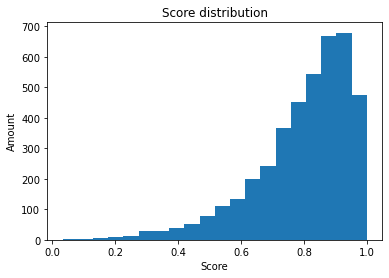

In [386]:
# calculate score
score = (df.total_positive/df.total_reviews)

# plot distribution
plt.hist(score, bins=20)
plt.xlabel("Score")
plt.ylabel("Amount")
plt.title("Score distribution")


In [387]:
df["platforms"].loc[0]

"{'windows': True, 'mac': False, 'linux': False}"

In [388]:
literal_eval(str(df["platforms"].loc[0]).replace("''",'None'))["windows"]

True

In [389]:
# experimental stuff. Needs discussion before proceeding!

In [390]:
# maybe isolate Singeplayer, Multiplayer, Shared/Split Screen Co-op, Co-op, Online Co-op, Online PvP, Shared/Split Screen, MMO

In [391]:
# how to encode Age?, Add relase date as ordinal data?(if yes, encode how?)